## Importing Relevant Packages

In [1]:
######################################################################
#                         IMPORT PACKAGES                            #
######################################################################
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import *
from matplotlib.collections import PatchCollection
from IPython.display import clear_output
import time
import random
from joblib import Parallel, delayed
import multiprocessing
import networkx as nx
import os
from steinernetworkx import connect_graph #import modified steiner tree code
random.seed()

## Computing Visibility and Connectivity Graphs
Uses a new "nondeterministic selection" method to compute the visibility graph in comparable time to parallelization.  Will speed up in future work

In [2]:
######################################################################
#                     PARAMETERS AND FUNCTIONS                       #
######################################################################

# Calculates if points s and t are visibile to each other
def Cvis(pt1,pt2):
    result = And([Or( ((pt1[0]-O[i][0])*(pt2[0]-O[i][0]) > 0), ((pt1[1]-O[i][1])*(pt2[1]-O[i][1]) > 0))
                    for i in range(numobjects)])
    return is_true(simplify(result))

#OUTPUT PREFERENCES
makeplots = True
logicalsoutput = False
modeltoterminal = False
randomobjects = False
modeltxt = False
mapchoice = 'UCLA'
parallel = False
nondet = True


#ALLOWANCE REFERENCES:
# UCLA MAP: 1 Meter ~ 2.2 pixels
# USC MAP: 1 Meter ~ 1.82 pixels
# ARL MAP: 1 Meter ~ 1.53 pixels
sensing_radius = 80#float('inf') #distance each camera can see, in pixels on image
connectivity_radius = 120

if mapchoice == 'UCLA':
    UCLAmap = True
    USCmap = False
    ARLmap = False
    GTmap = False
    manualmap = False
    xgrid = 33
    ygrid = 25
    numobjects = 378
elif mapchoice == 'USC':
    UCLAmap = False
    USCmap = True
    ARLmap = False
    GTmap = False
    manualmap = False
    xgrid = 26
    ygrid = 21
    numobjects = 175
elif mapchoice == 'ARL':
    UCLAmap = False
    USCmap = False
    ARLmap = True
    GTmap = False
    manualmap = False
    xgrid = 31
    ygrid = 27
    numobjects = 246
elif mapchoice == 'GT': #may be a tad bit too large, consider cutting down
    UCLAmap = False
    USCmap = False
    ARLmap = False
    GTmap = True
    manualmap = False
    xgrid = 50
    ygrid = 51
    numobjects = 815
elif mapchoice == 'manual':
    UCLAmap = False
    USCmap = False
    ARLmap = False
    GTmap = False
    manualmap = True
    xgrid = 10
    ygrid = 10
    numobjects = 10

#OBJECT LOCATION IN GRID O[objectnumber][x=index 0, y = index 1]
O = [[] for i in range(numobjects)]


######################################################################
#                     DISTANCE CONSIDERATIONS                        #
######################################################################

#Edge weighting in each direction Costs[xpos][ypos] = [width, height]
#Costs = np.ones((xgrid,ygrid,2))
precalcstart = time.time()

#This chunk imports edge weights from UCLA map segment and formats them appropriately
Costs = np.empty((xgrid,ygrid,2))
if UCLAmap == True:
    xcosts = open('UCLAmapxcosts.txt',mode='r')
    ycosts = open('UCLAmapycosts.txt',mode='r')
elif USCmap == True:
    xcosts = open('USCmapxcosts.txt',mode='r')
    ycosts = open('USCmapycosts.txt',mode='r')
elif ARLmap == True:
    xcosts = open('ARLmapxcosts.txt',mode='r')
    ycosts = open('ARLmapycosts.txt',mode='r')
elif GTmap == True:
    xcosts = open('GTmapxcosts.txt',mode='r')
    ycosts = open('GTmapycosts.txt',mode='r')
if manualmap == False:
    x = 0
    xvals = xcosts.readlines()
    yvals = ycosts.readlines()
    for i in xvals:
        y = 0
        xc = i.replace("\n","")
        for j in yvals:
            yc = j.replace("\n","")
            Costs[x,y,0] = float(xc)
            Costs[x,y,1] = float(yc)
            y += 1
        x += 1
    xcosts.close()
    ycosts.close()
elif manualmap == True:
    Costs = np.ones((xgrid,ygrid,2))

#this chunk imports object locations from UCLA map segment
objlocs = 0
if UCLAmap == True:
    randomobjects = False
    objlocs = open('UCLAmapobjects.txt',mode='r')
elif USCmap == True:
    randomobjects = False
    objlocs = open('USCmapobjects.txt',mode='r')
elif ARLmap == True:
    randomobjects = False
    objlocs = open('ARLmapobjects.txt',mode='r')
elif GTmap == True:
    randomobjects = False
    objlocs = open('GTmapobjects.txt',mode='r')
locs = []
if not(objlocs == 0):
    for i in objlocs:
        loc = i.replace("\n","")
        loc = loc.split(",")
        locs.append(loc)
    locs = [[int(i[0]), int(i[1])] for i in locs]
    objlocs.close()
    O = locs

    
vis = [[set() for i in range(ygrid)] for j in range(xgrid)]

locations = [] #generate list of all potential object locations (gridspace - object locations)
for i in range(xgrid):
	for j in range(ygrid):
		locations.append((i, j))
for o in range(numobjects): #select random option from list (if desired)
	if randomobjects == True:
		O[o] = random.choice(locations)
	locations.remove((O[o][0],O[o][1]))	#remove selected option from list (no sensors on objects, no doubly placed objects)

conn_graph = nx.Graph()
conn_graph.add_nodes_from(locations)
    
Dists = np.ones([xgrid,ygrid,xgrid,ygrid])*np.inf #Start distances at infinity (so objects are not 'seeable')
for pt1 in range(len(locations)):
    for pt2 in range(pt1,len(locations)):
        x = sum(Costs[min(locations[pt1][0],locations[pt2][0]):max(locations[pt1][0],locations[pt2][0])+1,locations[pt1][1],0])
        y = sum(Costs[locations[pt1][0],min(locations[pt1][1],locations[pt2][1]):max(locations[pt1][1],locations[pt2][1])+1,1])
        maxdist = np.sqrt(x**2 + y**2)
        Dists[locations[pt1][0],locations[pt1][1],locations[pt2][0],locations[pt2][1]] = maxdist
        Dists[locations[pt2][0],locations[pt2][1],locations[pt1][0],locations[pt1][1]] = maxdist #Abuse symmetry
        if (maxdist <= sensing_radius):
            vis[locations[pt1][0]][locations[pt1][1]].add(locations[pt2])
        if (maxdist <= connectivity_radius) and (pt1 != pt2):
            conn_graph.add_edge(locations[pt1],locations[pt2])


vis_graph = nx.Graph()
vis_graph.add_nodes_from(locations)
if nondet == True:
    count = 0
    nondettimes = time.time()
    for u1 in locations:
        #print('initial, point',u1,':',vis[u1[0]][u1[1]])
        while any(vis[u1[0]][u1[1]]) :
            u2 = random.choice(tuple(vis[u1[0]][u1[1]]))
            #print('choice:',u2)
            if Cvis(u1,u2):
                #Generates square of spaces with u1 and u2 at corners
                conv = {(x,y) for y in range(min(u1[1],u2[1]),max(u1[1],u2[1])+1) 
                                for x in range(min(u1[0],u2[0]),max(u1[0],u2[0])+1)}
                #vis[u1[0]][u1[1]] = [x for x in vis[u1[0]][u1[1]] if x not in conv]
                #print('conv:',conv)
                #print('vis:',vis[u1[0]][u1[1]])
                vis[u1[0]][u1[1]].difference_update(conv)
                for e1 in conv:
                    for e2 in conv:
                        vis_graph.add_edge(e1,e2)
                        vis[e1[0]][e1[1]].discard(e2)
            else :
                vis[u1[0]][u1[1]].remove(u2)
        count+=1
        #print('pass',count,'complete')
        clear_output(wait=True)
        print('%d %% calculated' % (count/len(locations)*100))
    print('New time:',time.time()-nondettimes)
else :
    ######################################################################
    #                    GENERATE VISIBLE SETS                           #
    ######################################################################
    # Pull only the points that are within allow of each other
    vis = np.transpose(np.nonzero(Dists <= sensing_radius))
    vis = vis.tolist()
    for el in vis:
        if [el[0],el[1]] == [el[2],el[3]]:
            continue
        else :
            vis.remove([el[2],el[3],el[0],el[1]]) #Abuse symmetry


    # can be done in parallel if desired
    if parallel == True:
        start = time.time()
        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(Cvis)((i[0],i[1]),(i[2],i[3])) for i in vis)
        #print('Parallel compute time:',np.floor((time.time() - start)/60) ,'minutes', (time.time() - start)%60 ,'seconds')
        for i, pt in enumerate(vis):
            pt1 = (pt[0],pt[1])
            pt2 = (pt[2],pt[3])
            if results[i]:
                vis_graph.add_edge(pt1,pt2)
    else:
        for pt in vis:
            if Cvis((pt[0],pt[1]),(pt[2],pt[3])):
                vis_graph.add_edge((pt[0],pt[1]),(pt[2],pt[3]))

# Output the precalculation/prep time for benchmark purposes
precalctime = time.time() - precalcstart
print('PRECALCULATION COMPLETED')
print('Total precalculation time:', np.floor(precalctime/60),'minutes', precalctime%60,'seconds')

100 % calculated
New time: 35.584697008132935
PRECALCULATION COMPLETED
Total precalculation time: 0.0 minutes 37.267083168029785 seconds


## Feasibility Checks
Can be used to check if there are any isolated nodes in visibility graph (coverage impossible).
Can checks if full connectivity graph is not connected (connectivity impossible)

In [3]:
isolates = list(nx.isolates(vis_graph))
connectivity_reachable = nx.is_connected(conn_graph)
if isolates or not connectivity_reachable:
    print('Infeasible setup!')
    if isolates:
        print('%s un-coverable regions exist.' % len(isolates))
    if not connectivity_reachable:
        print('No connected subgraph exists.')

## SAT and Closure Implementation
Initially uses SAT to compute a solution to the coverage problem.
If solution is not connected, follows this by collapsing subgraph of connectivity graph induced by SAT solution and computing steiner tree problem apprximation.  Then maps result back to initial space and adds necessary nodes, reporting number required to connect.

### Input Coverage Parameters

In [81]:
######################################################################
#                       PROBLEM PARAMETERS                          #
######################################################################

pos_inputs = ['yes', 'Yes', 'YES', 'y']
neg_inputs = ['no', 'n', 'No', 'NO']
multiplace = []

numcams = 380#number of cameras to be used
coverlevel = 3 #number of cameras to cover each block

solonodes = []
for loc in locations:
    if vis_graph.degree[loc] < coverlevel+1 :
        solonodes += loc
if solonodes :
    print('%s nodes do not have k = %s distinct neighbors.' %(len(solonodes),coverlevel))
    print('Will allow for multiple sensors in single space.')
    multiplace = 'yes'
    layercount = coverlevel
while multiplace not in pos_inputs and multiplace not in neg_inputs :
    multiplace = input('Would you like to permit multiple nodes placed in the same space? (yes/no) ')
    if multiplace in pos_inputs :
        print('Allowing multiple placement.')
        layercount = coverlevel
    elif multiplace in neg_inputs :
        print('Not allowing multiple placement.')
        layercount = 1
    else :
        print('Invalid input.')

136 nodes do not have k = 3 distinct neighbors.
Will allow for multiple sensors in single space.


### Begin SAT + Connectivity

In [65]:
######################################################################
#                     CONSTRAINT GENERATION                          #
######################################################################
constrstart = time.time()

#Boolean grid variables, True where cameras are to be placed C[xpos][ypos] = T/F
C = [[[Bool('C[%s][%s][%s]' % (j,i,k)) for k in range(layercount)] for i in range(ygrid)] for j in range(xgrid)]

# Create a list of visibility constraints
# At each point (x,y), select at least coverlevel locations that are visible to (x,y)
visibility = []
for node in locations:
    visibility.append(Sum([If(C[nbr[0]][nbr[1]][k],1,0) for nbr in vis_graph.adj[node] for k in range(layercount)]) >= coverlevel)

# Limit the number of squares that can be True -- only use numcams cameras
camnumconstr = []
camnumconstr.append(Sum([If(C[pt[0]][pt[1]][k],1,0) for pt in locations for k in range(layercount)]) == numcams)

# At least contain only connected sub-components                          
connectivity = []
for pt1 in locations:
    connectivity.append(Implies(Or([C[pt1[0]][pt1[1]][k] for k in range(layercount)])
                                ,Or([C[pt2[0]][pt2[1]][k] for k in range(layercount) 
                                     for pt2 in conn_graph.adj[pt1]])))                           

# Do not select object locations to be camera locations
notobject = []
for o in range(numobjects) :
    for k in range(layercount) :
        notobject.append(C[O[o][0]][O[o][1]][k] == False)

addlconstr = []    
#EXAMPLE EXTRA CONSTRAINT:
#UCLA MAP - Cover central courtyard extra well
#for i in range(15,18):
#    for j in range(3,21):
#        addlconstr.append(Sum([If(C[pt2[0]][pt2[1]],1,0) for pt2 in l[i][j]]) >= coverlevel+1)


# Output time generating constraints for benchmarking purposes
constrainttime = time.time() - constrstart
print('Constraint calculation time:', np.floor(constrainttime/60), 'm', constrainttime%60, 's')

######################################################################
#                          RUNNING SOLVER                            #
######################################################################
s = Solver()

solverstart = time.time()
s.add(visibility)
s.add(camnumconstr)
s.add(notobject)
#s.add(connectivity)

if addlconstr:
    s.add(addlconstr)
satcheck = s.check()
solvertime = time.time() - solverstart
connectionstart = time.time()
connected = False
added_nodes = 0
if satcheck == sat:
    m = s.model()
    #create list of locations
    sol = []
    numplaced = np.zeros((xgrid,ygrid))
    for pt in locations:
        for k in range(layercount) : # Count how many at each location
            if m.evaluate(C[pt[0]][pt[1]][k]) :
                numplaced[pt[0],pt[1]] += 1
        if numplaced[pt[0],pt[1]] > 0 :
            sol.append(tuple(pt))
    sol_graph = conn_graph.subgraph(sol)
    connected = nx.is_connected(sol_graph)
    original_number_nodes = sol_graph.order()
    if connected :
        final_graph = sol_graph
    if not connected :
        avail = set(conn_graph.edges()).difference(set(sol_graph.edges()))
        aug_edges = connect_graph(sol_graph,conn_graph,avail)
        to_add = list(sol_graph.edges())+list(aug_edges)
        final_graph = conn_graph.edge_subgraph(to_add)
        added_nodes = final_graph.order() - original_number_nodes
        connected = nx.is_connected(final_graph)

connectiontime = time.time() - connectionstart
        
print('Solver runtime :', np.floor(solvertime/60), 'm', solvertime%60,'s')
print('Connection algorithm runtime :', np.floor(connectiontime/60), 'm', connectiontime%60,'s')
print('Total elapsed time :', np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
print('SOLVER STATUS:',satcheck)
print('CONNECTED STATUS:', connected,', after adding',added_nodes,'nodes')

Constraint calculation time: 0.0 m 2.9909350872039795 s
Solver runtime : 0.0 m 19.65303897857666 s
Connection algorithm runtime : 0.0 m 0.7328908443450928 s
Total elapsed time : 0.0 m 59.911057233810425 s
SOLVER STATUS: sat
CONNECTED STATUS: True , after adding 2 nodes


## Visualization
Generates "before" and "after" plots for SAT result and fully connected result (if connection step necessary.)
Plots nodes in red, with lines drawn between nodes if they are within connectivity radius of each other.
Plots "added" nodes for connectivity slightly larger, in blue.
Underset heatmap displays level of coverage at each point in discrete space.
(Sizing of some plot points may need to be adjusted for a nice image.)


		PROBLEM: SATISFIABLE				    
Map: UCLA
Number of cameras: 382
Cover level: 3
Added nodes: 2
Total computation time : 0.0 m 59.911057233810425 s
Pre-calculation time: 0.0 m 37.267083168029785 s
Constraint generation : 0.0 m 2.9909350872039795 s
Solver runtime : 0.0 m 19.65303897857666 s


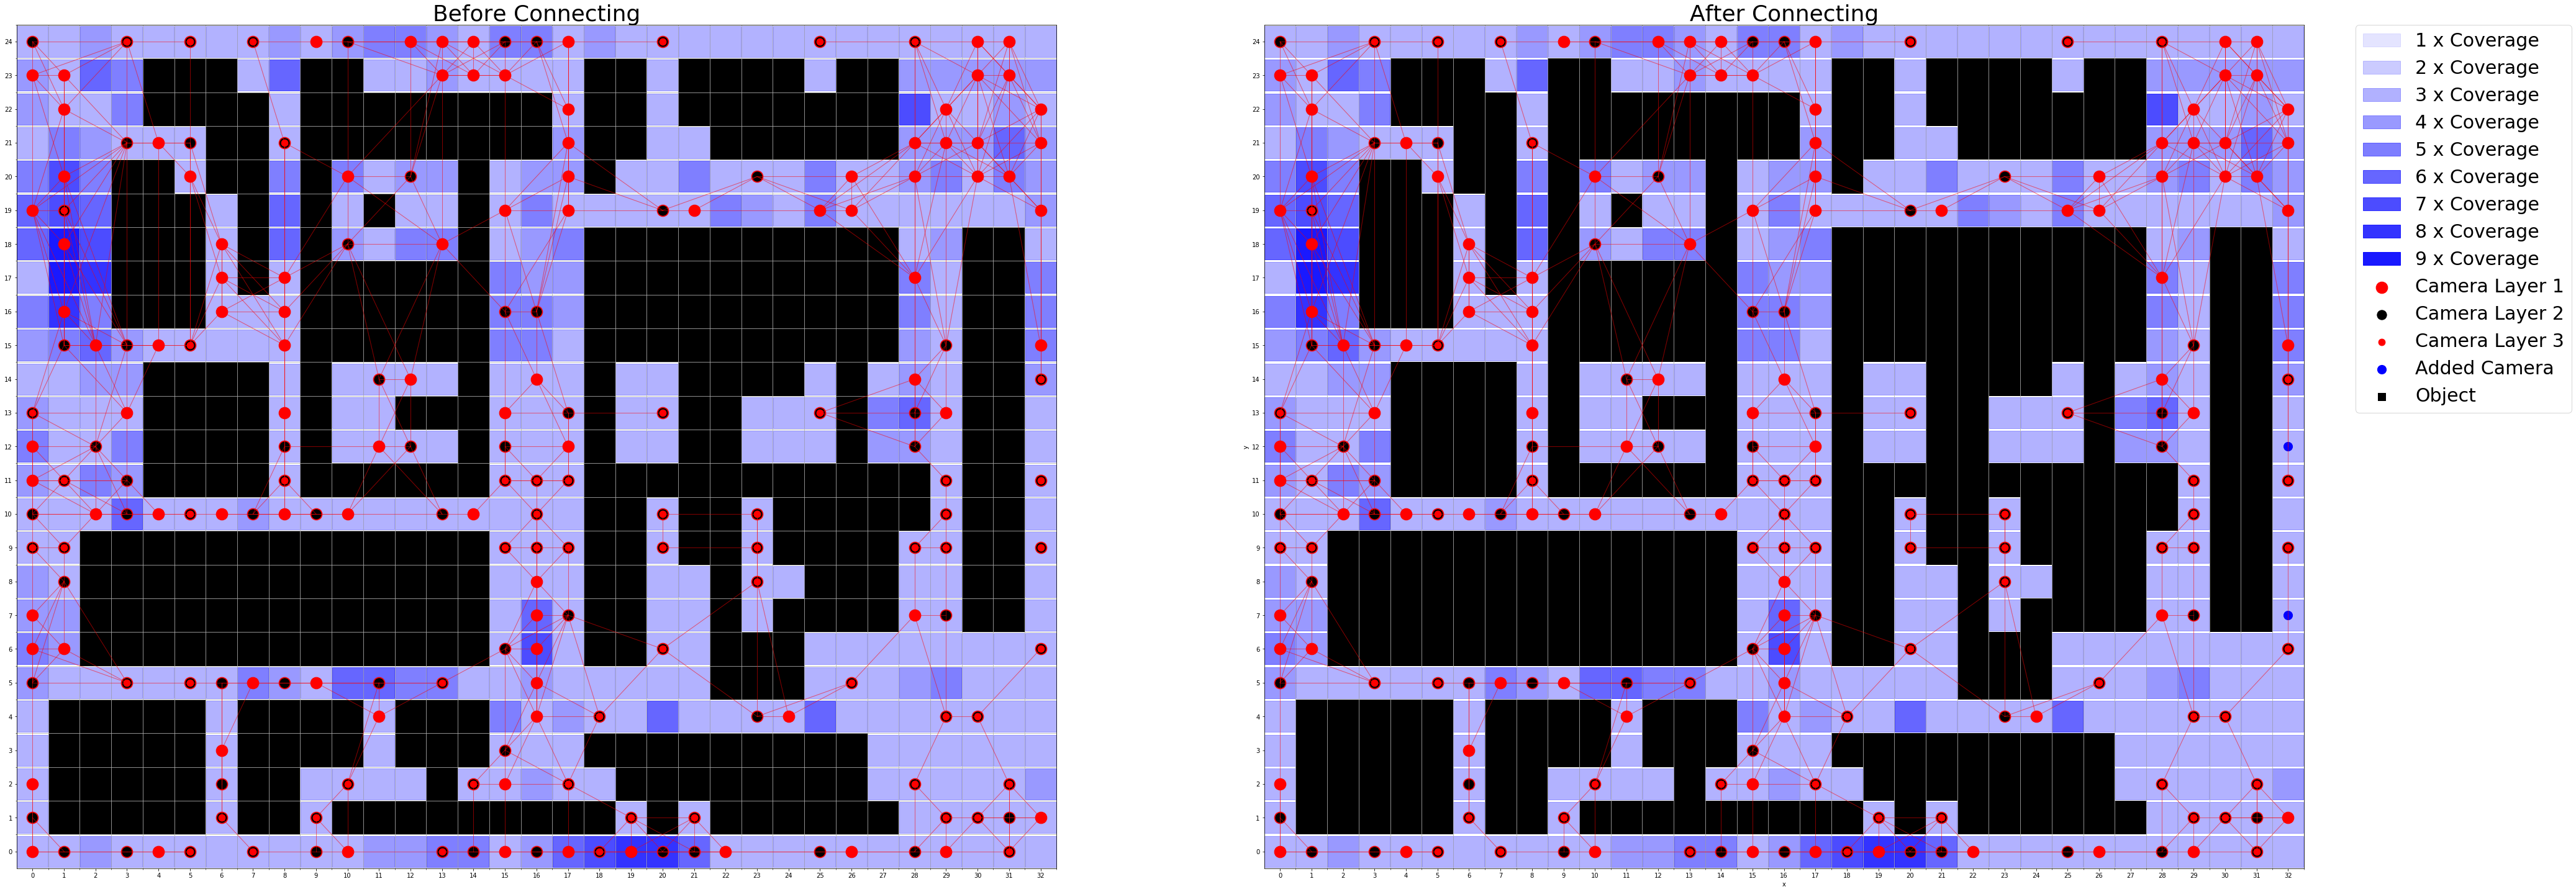

In [75]:
if satcheck == sat:
	print ('\n=======================================================')
	print ('		PROBLEM: SATISFIABLE				    ')
	print ('=======================================================')
	print ('Map:', mapchoice)
	print ('Number of cameras:', numcams+added_nodes)
	print ('Cover level:', coverlevel)
	print ('Added nodes:', added_nodes)
	print ('Total computation time :',np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
	print ('Pre-calculation time:', np.floor(precalctime/60),'m',precalctime%60,'s')
	print ('Constraint generation :', np.floor(constrainttime/60), 'm', constrainttime%60, 's')
	print('Solver runtime :', np.floor(solvertime/60), 'm', solvertime%60,'s')
else:
	print('\n=======================================================')
	print('		PROBLEM: INFEASIBLE				    ')
	print('=======================================================')
	print ('Map:', mapchoice)
	print ('Number of cameras:', numcams)
	print ('Cover level:', coverlevel)
	print('Total computation time :',np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
	print('Pre-calculation time:', np.floor(precalctime/60),'m',precalctime%60,'s')
	print('Constraint generation :', np.floor(constrainttime/60), 'm', constrainttime%60, 's')

if satcheck == sat and added_nodes != 0:
    scale = 1.0
	#parses model strings for camera locations, works because of alphabetized variable names...
    initcams = list(sol_graph.nodes())
    finalcams = list(final_graph.nodes())
    datamap = plt.figure(figsize=(2*xgrid/scale,ygrid/scale))
    #create subplot layer for objects and gridlines
    ax1 = datamap.add_subplot(121)
    ax2 = datamap.add_subplot(122)
    #Set x and y axis markers
    xaxis = range(0,xgrid)
    yaxis = range(0,ygrid)
    ax1.set_xticks(xaxis)
    ax1.set_yticks(yaxis)
    ax2.set_xticks(xaxis)
    ax2.set_yticks(yaxis)

    #plot squares where objects are
    #creates list of squares with one for each object
    obstacles = []

    for i in range(numobjects):
        objmap = patches.Rectangle((O[i][0]-0.5,O[i][1]-0.5), 1, 1)
        obstacles.append(objmap)
    obstaclesquares1 = PatchCollection(obstacles, facecolor = 'black', label = 'Object')
    obstaclesquares2 = PatchCollection(obstacles, facecolor = 'black', label = 'Object')
    ax1.add_collection(obstaclesquares1)
    ax2.add_collection(obstaclesquares2)
    #set plot limits so all of the boxes are visible
    ax1.set_ylim([-0.5,ygrid-0.5])
    ax1.set_xlim([-0.5,xgrid-0.5])
    ax2.set_ylim([-0.5,ygrid-0.5])
    ax2.set_xlim([-0.5,xgrid-0.5])

    textsize = 100
    initheatmap = np.zeros((xgrid,ygrid))
    finalheatmap = np.zeros((xgrid,ygrid))
    alphaval = 0.1
    if satcheck == sat:
        InitCamlocs = np.array(initcams)
        FinalCamlocs = np.array(finalcams)
        for loc in InitCamlocs:
            for el in vis_graph[(loc[0],loc[1])]:
                initheatmap[el[0],el[1]] += 1*numplaced[loc[0],loc[1]]
        newnodes = set(final_graph.nodes()).difference(sol_graph.nodes())
        newnodes = np.array(list(newnodes))
        for loc in FinalCamlocs:
            for el in vis_graph[(loc[0],loc[1])]:
                finalheatmap[el[0],el[1]] += 1*numplaced[loc[0],loc[1]]
        if alphaval*np.max(initheatmap) > 1:
            alphaval = 1.0/np.max(initheatmap)
        if alphaval*np.max(finalheatmap) > 1:
            alphaval = 1.0/np.max(finalheatmap)
        for loc in locations:
            ax1.scatter(loc[0],loc[1], c = 'blue', marker = 's', s = 2500, alpha = initheatmap[loc[0],loc[1]]*alphaval)
            ax2.scatter(loc[0],loc[1], c = 'blue', marker = 's', s = 2500, alpha = finalheatmap[loc[0],loc[1]]*alphaval)
            #plt.scatter(C[i][0],C[i][1], marker = '$C%s$' % (i+1), s = textsize)
        
        camcolors = ['red', 'black']
        initcamplots = []
        maxlayer = np.max(numplaced)
        for layer in range(layercount) :
            toplot = np.argwhere(numplaced > layer)
            #initcamplots.append(ax1.scatter(toplot[:,0],toplot[:,1], c = camcolors[layer % 2], marker = 'o',s=350/((layer+1.0)**1.5), label='Camera'))
            initcamplots.append(ax1.scatter(toplot[:,0],toplot[:,1], c = camcolors[layer % 2], marker = 'o',s=350*(-layer/maxlayer+1.0), label='Camera Layer %s' % (layer+1)))
            ax2.scatter(toplot[:,0],toplot[:,1], c = camcolors[layer % 2], marker = 'o',s=350*(-layer/maxlayer+1.0), label='Camera Layer %s' % (layer+1))
        addedcamplots = ax2.scatter(newnodes[:,0],newnodes[:,1], c = 'blue', marker = 'o', s = 200, label='Added Camera')

    #plot where the objects are with white O#'s on top of the black square
    #for i in range(numobjects):
    Objlocs = np.array(O)
    objplots = ax1.scatter(Objlocs[:,0],Objlocs[:,1], marker = 's', s = 150, color = 'black', label='Object')
    ax2.scatter(Objlocs[:,0],Objlocs[:,1], marker = 's', s = 150, color = 'black', label='Object')
    for i,cam1 in enumerate(InitCamlocs):
            for j,cam2 in enumerate(InitCamlocs):
                if ((cam2[0],cam2[1]) in conn_graph[cam1[0],cam1[1]]) :
                    ax1.plot([InitCamlocs[i,0],InitCamlocs[j,0]],[InitCamlocs[i,1],InitCamlocs[j,1]],c='red',linewidth=1,alpha=0.3)
    for i,cam1 in enumerate(FinalCamlocs):
            for j,cam2 in enumerate(FinalCamlocs):
                if ((cam2[0],cam2[1]) in conn_graph[cam1[0],cam1[1]]) :
                    ax2.plot([FinalCamlocs[i,0],FinalCamlocs[j,0]],[FinalCamlocs[i,1],FinalCamlocs[j,1]],c='red',linewidth=1,alpha=0.3)

    handlelist = []
    for i in range(int(np.max(initheatmap))):
        handlelist += [patches.Patch(color='blue',alpha=(i+1)*alphaval,label=('%s x Coverage' % (i+1)))]
    for element in initcamplots :
        handlelist += [element]
    handlelist += [addedcamplots]
    handlelist += [objplots]
    #create gridlines in the correct locations
    minor_locatorx = AutoMinorLocator(2)
    minor_locatory = AutoMinorLocator(2)
    ax1.xaxis.set_minor_locator(minor_locatorx)
    ax1.yaxis.set_minor_locator(minor_locatory)
    ax2.xaxis.set_minor_locator(minor_locatorx)
    ax2.xaxis.set_minor_locator(minor_locatory)
    ax1.grid(which='minor')
    ax2.grid(which='minor')
    ax1.set_title('Before Connecting',fontsize = 36)
    ax2.set_title('After Connecting', fontsize = 36)
    plt.xlabel('x')
    plt.ylabel('y')
    ax1.legend(handles=handlelist,bbox_to_anchor=(2.25, 1), loc=2, fontsize = 30, borderaxespad=0.)
    plt.savefig('Comparison.png')
    plt.show()


else:    
    cams = list(final_graph.nodes())
    scale = 2
    #create plot object
    datamap = plt.figure(figsize=(xgrid/scale,ygrid/scale))
    #create subplot layer for objects and gridlines
    ax = datamap.add_subplot(111)

    #Set x and y axis markers
    xaxis = range(0,xgrid)
    yaxis = range(0,ygrid)
    plt.xticks(xaxis)
    plt.yticks(yaxis)

    #plot squares where objects are
    #creates list of squares with one for each object
    obstacles = []

    for i in range(numobjects):
        objmap = patches.Rectangle((O[i][0]-0.5,O[i][1]-0.5), 1, 1)
        obstacles.append(objmap)
    obstaclesquares = PatchCollection(obstacles, facecolor = 'black', label = 'Object')
    ax.add_collection(obstaclesquares)

    #set plot limits so all of the boxes are visible
    plt.ylim(-0.5,ygrid-0.5)
    plt.xlim(-0.5,xgrid-0.5)

    textsize = 100
    heatmap = np.zeros((xgrid,ygrid))
    alphaval = 0.1
    if satcheck == sat:
        Camlocs = np.array(cams)
        for loc in Camlocs:
            for el in vis_graph[(loc[0],loc[1])]:
                heatmap[el[0],el[1]] += 1
        if alphaval*np.max(heatmap) > 1:
            alphaval = 1.0/np.max(heatmap)
        for loc in locations:
            ax.scatter(loc[0],loc[1], c = 'blue', marker = 's', s = 740, alpha = heatmap[loc[0],loc[1]]*alphaval)
            #plt.scatter(C[i][0],C[i][1], marker = '$C%s$' % (i+1), s = textsize)
        camplots = ax.scatter(Camlocs[:,0],Camlocs[:,1], c = 'red', marker = 'o',s=150, label='Camera')



    #plot where the objects are with white O#'s on top of the black square
    #for i in range(numobjects):
    Objlocs = np.array(O)
    objplots = ax.scatter(Objlocs[:,0],Objlocs[:,1], marker = 's', s = 150, color = 'black', label='Object')

    for i,cam1 in enumerate(Camlocs):
            for j,cam2 in enumerate(Camlocs):
                if ((cam2[0],cam2[1]) in conn_graph[cam1[0],cam1[1]]) :
                    ax.plot([Camlocs[i,0],Camlocs[j,0]],[Camlocs[i,1],Camlocs[j,1]],c='red',linewidth=1,alpha=0.3)

    handlelist = []
    for i in range(int(np.max(heatmap))):
        handlelist += [patches.Patch(color='blue',alpha=(i+1)*alphaval,label=('%s x Coverage' % (i+1)))]
    handlelist += [camplots]
    handlelist += [objplots]
    #create gridlines in the correct locations
    minor_locatorx = AutoMinorLocator(2)
    minor_locatory = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locatorx)
    ax.yaxis.set_minor_locator(minor_locatory)
    plt.grid(which='minor')
    plt.xlabel('x')
    plt.ylabel('y')
    ax.legend(handles=handlelist,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    #plt.tight_layout()
    if GTmap == True:
        plt.savefig('GTDiscreteResult.png')
    elif UCLAmap == True:
        plt.savefig('UCLADiscreteResult.png')
    elif USCmap == True:
        plt.savefig('USCDiscreteResult.png')
    elif ARLmap == True:
        plt.savefig('ARLDiscreteResult.png')
    plt.show()